In [2]:
import pandas as pd
import numpy as np
import altair as alt

### LOAD DATA FROM FILES 2000 - 2020

In [3]:
cols = [
    'Year',
    'Trade Flow',
    'Reporter',
    'Reporter Code',
    'Reporter ISO',
    'Partner',
    'Partner Code',
    'Partner ISO',
    'Trade Value (US$)',
    'Commodity',
    'Commodity Code'
]

data = pd.DataFrame([])

for year in range(2000, 2021):
    df = pd.read_csv(
        'data/total-trade-value-{year}.csv'.format(year = year),
        usecols = cols
    )
    
    data = pd.concat([data, df])

In [4]:
data.head()

,Year,Trade Flow,Reporter Code,Reporter,Reporter ISO,Partner Code,Partner,Partner ISO,Commodity Code,Commodity,Trade Value (US$)
0,2000,Import,643,Russian Federation,RUS,0,World,WLD,TOTAL,ALL COMMODITIES,33880091843
1,2000,Export,643,Russian Federation,RUS,0,World,WLD,TOTAL,ALL COMMODITIES,103092748421
2,2000,Import,643,Russian Federation,RUS,4,Afghanistan,AFG,TOTAL,ALL COMMODITIES,5421802
3,2000,Export,643,Russian Federation,RUS,4,Afghanistan,AFG,TOTAL,ALL COMMODITIES,11158588
4,2000,Import,643,Russian Federation,RUS,8,Albania,ALB,TOTAL,ALL COMMODITIES,666923


In [5]:
data.tail()

,Year,Trade Flow,Reporter Code,Reporter,Reporter ISO,Partner Code,Partner,Partner ISO,Commodity Code,Commodity,Trade Value (US$)
411,2020,Export,643,Russian Federation,RUS,887,Yemen,YEM,TOTAL,All Commodities,238268986
412,2020,Import,643,Russian Federation,RUS,894,Zambia,ZMB,TOTAL,All Commodities,11672031
413,2020,Export,643,Russian Federation,RUS,894,Zambia,ZMB,TOTAL,All Commodities,9494196
414,2020,Import,643,Russian Federation,RUS,899,"Areas, nes",NaN,TOTAL,All Commodities,257935052
415,2020,Export,643,Russian Federation,RUS,899,"Areas, nes",NaN,TOTAL,All Commodities,436712919


In [6]:
len(data)

8263

### TRADE TURNOVER

In [7]:
turnover_data = data.loc[
    data['Trade Flow'].isin(['Export', 'Import'])
].groupby(['Partner', 'Year', 'Partner Code', 'Partner ISO']).agg({
    'Trade Value (US$)': 'sum'
}).reset_index()

turnover_data.loc[:, 'Trade Flow'] = 'Turnover'

In [8]:
data = pd.concat([
    data,
    turnover_data
], sort=False).fillna(method = 'ffill')

In [9]:
data.loc[:, 'Reporter Code'] = data.loc[:, 'Reporter Code'].astype('int64')

In [10]:
len(data)

12716

### PARTNERS' SHARES

In [11]:
data = data.merge(
        data.loc[ data.Partner == 'World', ['Trade Value (US$)', 'Year', 'Trade Flow']],
        on = ['Year', 'Trade Flow'],
        how = 'inner',
        suffixes = ("", "_wld")
)

data.loc[:, 'Partner Pct'] = ((data.loc[:, 'Trade Value (US$)'] / data.loc[:, 'Trade Value (US$)_wld']) * 100).round(2)
data = data.drop('Trade Value (US$)_wld', axis=1)

### TOTAL/IMPORT/EXPORT TOP 10 PARTNERS BY YEAR

In [12]:
def top_partners(group):
    subgroup = group.sort_values(by='Trade Value (US$)', ascending=False)
    
    return subgroup.loc[subgroup.Partner != 'World', ['Partner', 'Partner Code', 'Partner Pct', 'Trade Value (US$)']].head(10).reset_index()

In [13]:
top_partners_stats = data.loc[
    data['Trade Flow'] != 'Re-Import'
].groupby([
    'Year', 'Trade Flow'
]).apply(
    top_partners
)

In [14]:
top_partners_stats = top_partners_stats.reset_index().rename(columns={'level_2': 'Rank'})
top_partners_stats.loc[:, 'Rank'] += 1

In [15]:
top_partners_stats.query('Year == 2020')

,Year,Trade Flow,Rank,index,Partner,Partner Code,Partner Pct,Trade Value (US$)
600,2020,Export,1,8105,China,156,14.58,49146337025
601,2020,Export,2,8191,Netherlands,528,7.36,24819406506
602,2020,Export,3,8253,United Kingdom,826,6.87,23158448968
603,2020,Export,4,8135,Germany,276,5.52,18618931252
604,2020,Export,5,8095,Belarus,112,4.74,15978568108
605,2020,Export,6,8247,Turkey,792,4.73,15929123041
606,2020,Export,7,8158,Kazakhstan,398,4.17,14051457813
607,2020,Export,8,8162,Rep. of Korea,410,3.70,12468100598
608,2020,Export,9,8255,USA,842,3.25,10958393455
609,2020,Export,10,8154,Italy,381,2.99,10071345439


In [16]:
#top_partners_stats.to_csv('data/top_partners_stats.csv', index=False)

### EDA

#### Subset countries for analysis

In [17]:
# Countries with at least 0.5% of Import/Export any year
subdata = data.loc[ data['Trade Flow'].isin(['Import', 'Export']) & (data['Partner Pct'] >= 0.5) ]
subcountries = np.unique(subdata.Partner)

In [18]:
subcountries

array(['Algeria', 'Areas, nes', 'Argentina', 'Australia', 'Austria',
       'Azerbaijan', 'Belarus', 'Belgium', 'Br. Virgin Isds', 'Brazil',
       'Bulgaria', 'Canada', 'China', 'China, Hong Kong SAR', 'Cuba',
       'Cyprus', 'Czechia', 'Denmark', 'Ecuador', 'Egypt', 'Estonia',
       'Finland', 'France', 'Germany', 'Gibraltar', 'Greece', 'Hungary',
       'India', 'Indonesia', 'Iran', 'Ireland', 'Israel', 'Italy',
       'Japan', 'Kazakhstan', 'Latvia', 'Lithuania', 'Malaysia', 'Malta',
       'Netherlands', 'Norway', 'Other Asia, nes', 'Other Europe, nes',
       'Poland', 'Rep. of Korea', 'Rep. of Moldova', 'Romania', 'Serbia',
       'Singapore', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
       'Switzerland', 'Tajikistan', 'Thailand', 'Turkey', 'Turkmenistan',
       'USA', 'Ukraine', 'United Arab Emirates', 'United Kingdom',
       'Uzbekistan', 'Viet Nam', 'World'], dtype=object)

In [19]:
len(subcountries)

65

In [20]:
# subset again with Turnover data
subdata = data.loc[ data.Partner.isin(subcountries)]

In [21]:
#subdata.loc[subdata['Trade Flow'] == "Import"].pivot(index="Partner", columns="Year", values="Partner Pct").sort_values(by=2020)

In [22]:
#subdata.loc[subdata['Trade Flow'] == "Export"].pivot(index="Partner", columns="Year", values="Partner Pct").sort_values(by=2020)

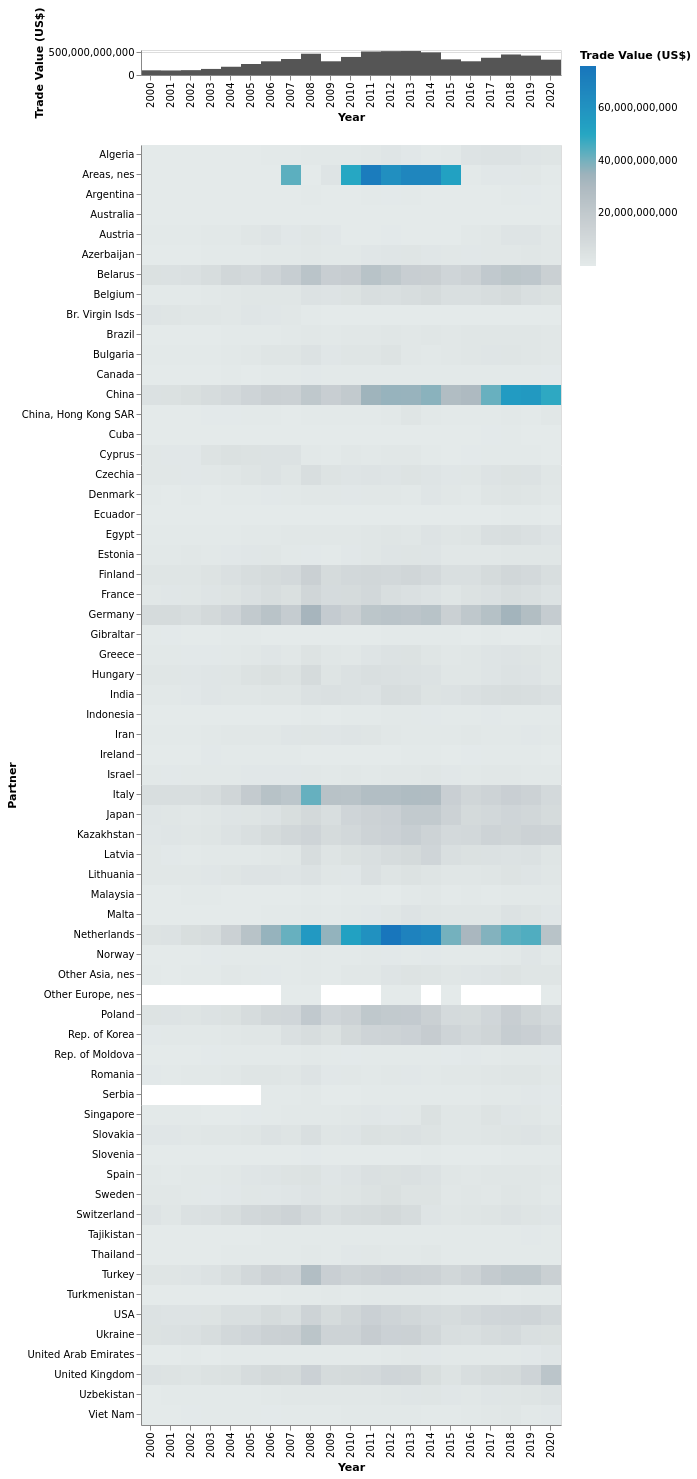

In [23]:
export_world_usd = alt.Chart(
    subdata.loc[
        (subdata['Trade Flow'] == 'Export') & (subdata.Partner == "World")
    ]
).mark_rect(color="#555555").encode(
    x='Year:O',
    y='Trade Value (US$)',
    #color='Trade Value (US$)'
).properties(
    height=25
)

export_partners_pct = alt.Chart(
    subdata.loc[
        (subdata['Trade Flow'] == 'Export') & (subdata.Partner != "World")
    ]
).mark_rect().encode(
    x='Year:O',
    y='Partner:O',
    color=alt.Color('Trade Value (US$)', scale=alt.Scale(scheme='lightgreyteal'))
)

alt.vconcat(export_world_usd, export_partners_pct)

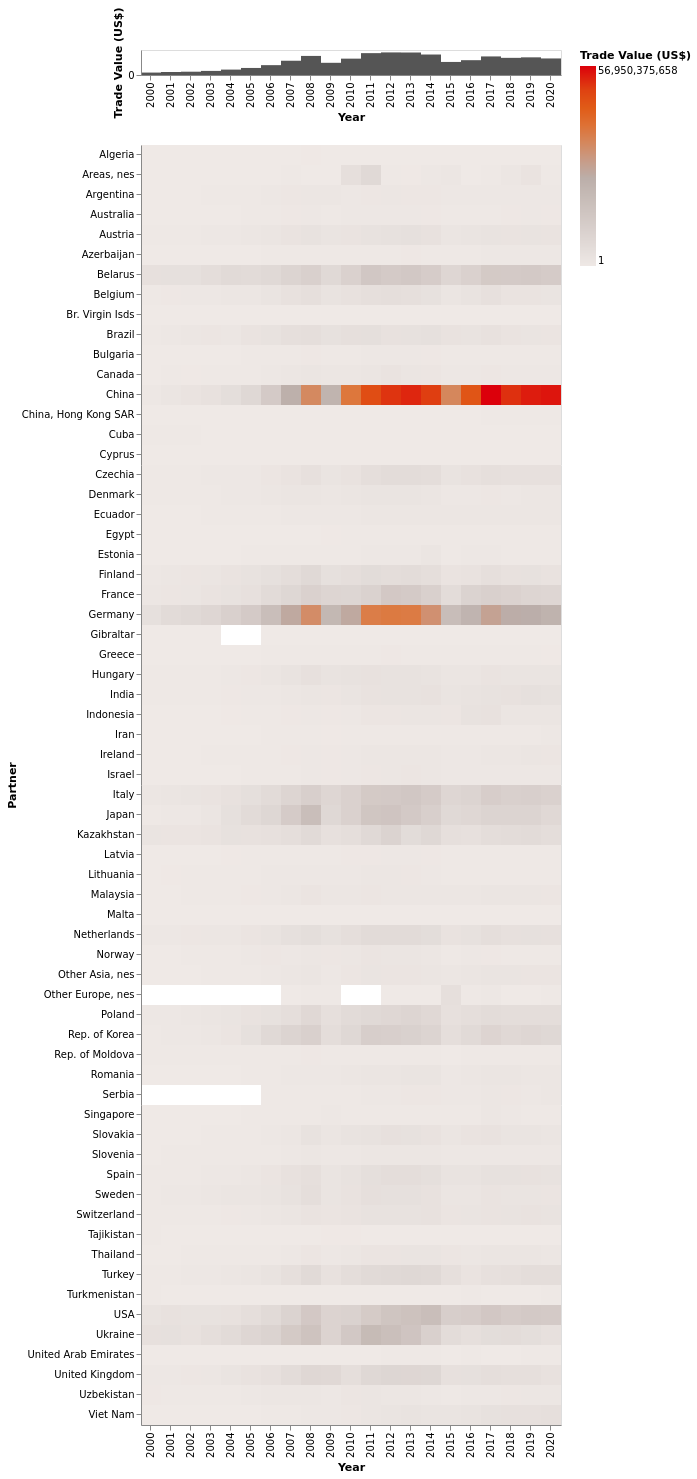

In [24]:
import_world_usd = alt.Chart(
    subdata.loc[
        (subdata['Trade Flow'] == 'Import') & (subdata.Partner == "World")
    ]
).mark_rect(color="#555555").encode(
    x='Year:O',
    y='Trade Value (US$)',
    #color='Trade Value (US$)'
).properties(
    height=25
)

import_partners_pct = alt.Chart(
    subdata.loc[
        (subdata['Trade Flow'] == 'Import') & (subdata.Partner != "World")
    ]
).mark_rect().encode(
    x='Year:O',
    y='Partner:O',
    color=alt.Color('Trade Value (US$)', scale=alt.Scale(scheme='lightgreyred'))
)

alt.vconcat(import_world_usd, import_partners_pct)

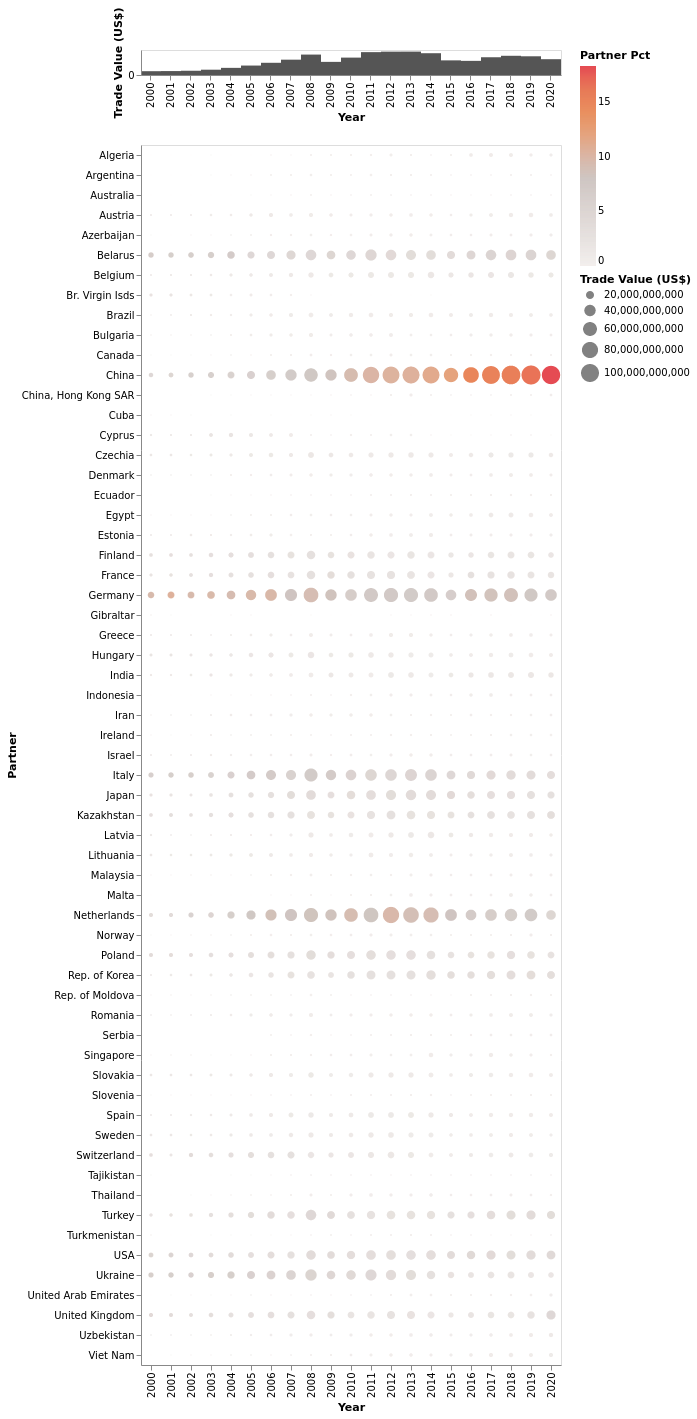

In [25]:
turnover_world_usd = alt.Chart(
    subdata.loc[
        (subdata['Trade Flow'] == 'Turnover') & (subdata.Partner == "World")
    ]
).mark_rect(color="#555555").encode(
    x='Year:O',
    y='Trade Value (US$)',
    #color='Trade Value (US$)'
).properties(
    height=25
)

turnover_partners_pct = alt.Chart(
    subdata.loc[
        (subdata['Trade Flow'] == 'Turnover') & (subdata.Partner != "World")
    ]
).mark_circle().encode(
    x='Year:O',
    y='Partner:O',
    size='Trade Value (US$)',
    color=alt.Color('Partner Pct', scale=alt.Scale(scheme='lightgreyred'))
)

alt.vconcat(turnover_world_usd, turnover_partners_pct)

(0, 527265918851)
(0, 76036013738)


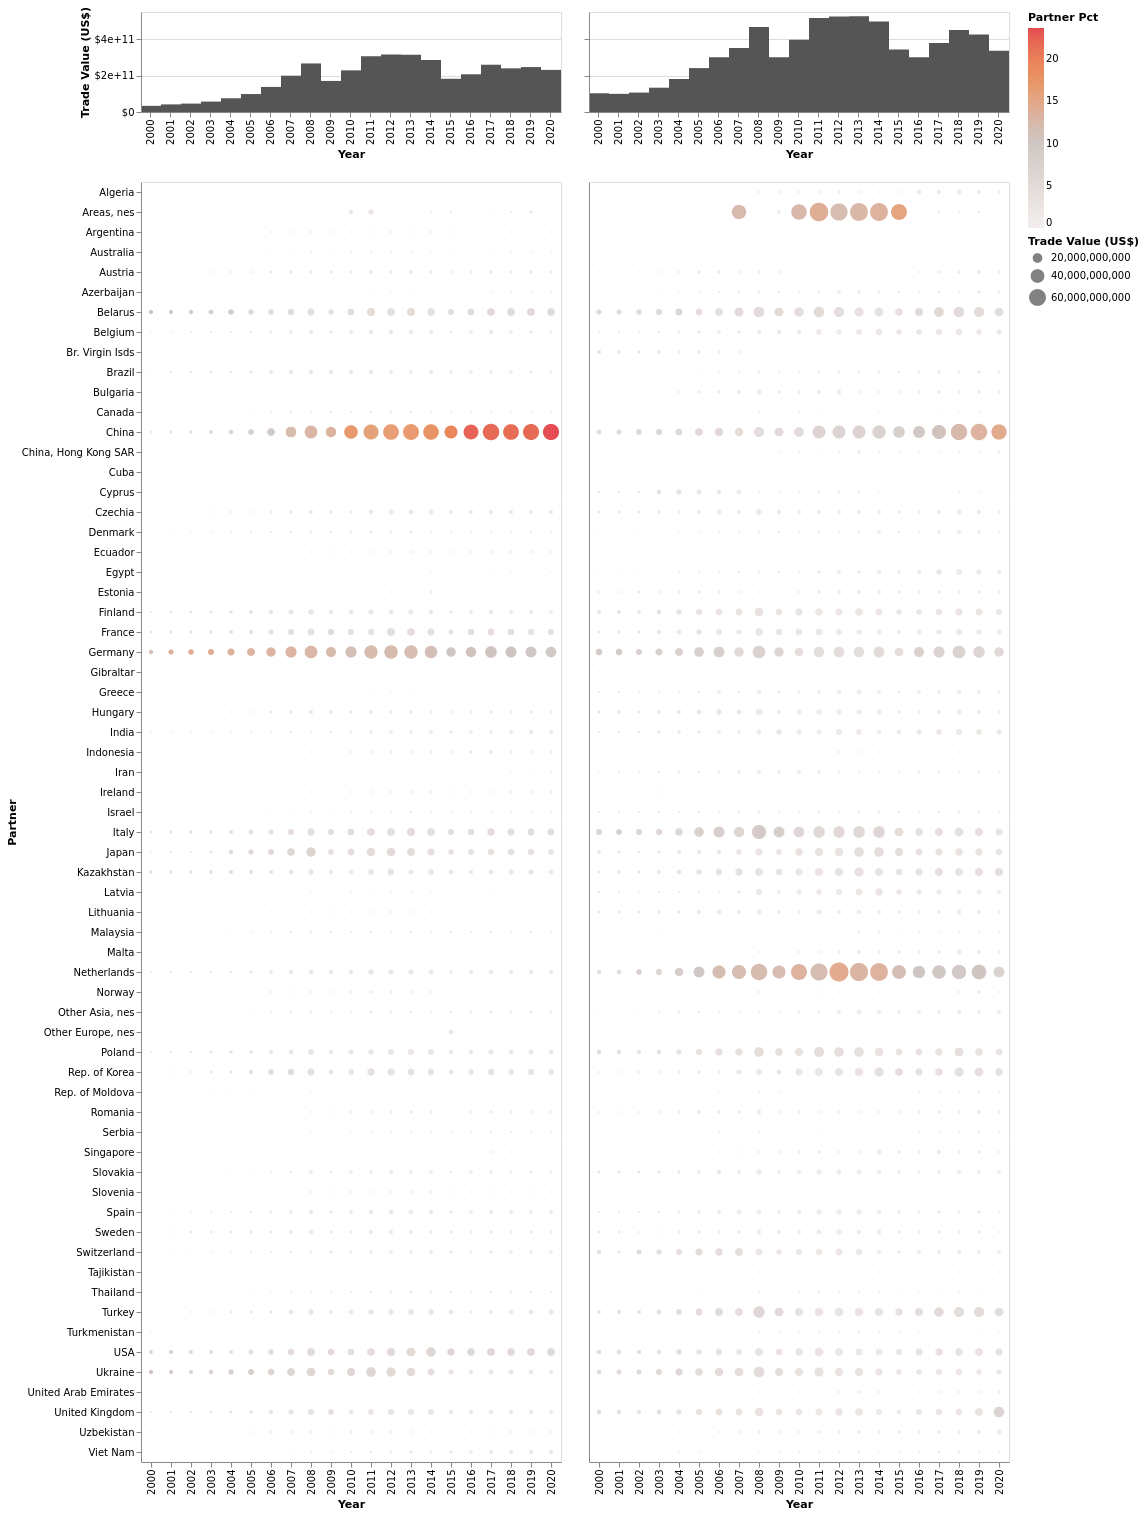

In [71]:
domain_world = (
    0,
    subdata.loc[
        (subdata['Trade Flow'].isin(['Import', 'Export'])) & (subdata.Partner == "World"),
        'Trade Value (US$)'
    ].max()
)

domain_partners = (
    0,
    subdata.loc[
        (subdata['Trade Flow'].isin(['Import', 'Export'])) & (subdata.Partner != "World"),
        'Trade Value (US$)'
    ].max()
)

print(domain_world)
print(domain_partners)

import_world = alt.Chart(
    subdata.loc[
        (subdata['Trade Flow'] == 'Import') & (subdata.Partner == "World")
    ]
).mark_rect(color="#555555").encode(
    alt.X('Year:O'),
    alt.Y(
        'Trade Value (US$):Q',
        scale=alt.Scale(domain=domain_world),
        axis=alt.Axis(format="$")),
    #color='Trade Value (US$)'
).properties(
    height=100
)

export_world = alt.Chart(
    subdata.loc[
        (subdata['Trade Flow'] == 'Export') & (subdata.Partner == "World")
    ]
).mark_rect(color="#555555").encode(
    alt.X('Year:O'),
    alt.Y(
        'Trade Value (US$)',
        scale=alt.Scale(domain=domain_world),
        axis=alt.Axis(labels=False, title=None)
    ),
    #color='Trade Value (US$)'
).properties(
    height=100
)

import_partners = alt.Chart(
    subdata.loc[
        (subdata['Trade Flow'] == 'Import') & (subdata.Partner != "World")
    ]
).mark_circle().encode(
    alt.X('Year:O'),
    alt.Y('Partner:O'),
    size=alt.Size('Trade Value (US$)', scale=alt.Scale(domain=domain_partners)),
    color=alt.Color('Partner Pct', scale=alt.Scale(scheme='lightgreyred')),
    tooltip=['Trade Flow', 'Year', 'Partner', 'Trade Value (US$)', 'Partner Pct']
).interactive()

export_partners = alt.Chart(
    subdata.loc[
        (subdata['Trade Flow'] == 'Export') & (subdata.Partner != "World")
    ]
).mark_circle().encode(
    alt.X('Year:O'),
    alt.Y('Partner:O', axis=alt.Axis(labels=False, ticks=False, title=None)),
    size=alt.Size('Trade Value (US$)', scale=alt.Scale(domain=domain_partners)),
    color=alt.Color('Partner Pct', scale=alt.Scale(scheme='lightgreyred')),
    tooltip=['Trade Flow', 'Year', 'Partner', 'Trade Value (US$)', 'Partner Pct']
).interactive()

alt.hconcat(
    alt.vconcat(import_world, import_partners),
    alt.vconcat(export_world, export_partners)
)